In [95]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [96]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [97]:
def validate_with_optical_flow(input_path, model, device,
                            threshold=0.5, mag_threshold=2.5, 
                            pixel_spacing=0.1, lv_length=10.0, max_frames=100):

    cap = cv2.VideoCapture(input_path)
    
    model.eval()
    frame_count = 0
    prev_mask = None
    valid_frames = []
    validation_metrics = []
    mask_areas = []
    
    plt.figure(figsize=(18, 6))
    
    with torch.no_grad():
        
        while cap.isOpened() and frame_count < max_frames:
            
            ret, frame = cap.read()
            
            if not ret:
                break
                
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_tensor = torch.from_numpy(frame_gray/255.).unsqueeze(0).unsqueeze(0).float().to(device)
            pred = model(frame_tensor)
            curr_mask = (pred > threshold).squeeze().cpu().numpy().astype(np.uint8)
            
            current_area = np.sum(curr_mask)
            mask_areas.append(current_area)
            
            metrics = {
                'frame': frame_count,
                'mean_magnitude': 0,
                'is_valid': False,
                'mask_area': current_area
            }
            
            if prev_mask is not None:
            
                prev_mask_flow = (prev_mask * 255).astype(np.uint8)
                curr_mask_flow = (curr_mask * 255).astype(np.uint8)
                flow = cv2.calcOpticalFlowFarneback(
                    prev_mask_flow, curr_mask_flow,
                    None, 0.5, 3, 15, 3, 5, 1.2, 0
                )
                
                y, x = np.where(curr_mask == 1)
                if len(y) > 0:
                    flow_vectors = flow[y, x]
                    magnitude, _ = cv2.cartToPolar(flow_vectors[...,0], flow_vectors[...,1])
                    mean_mag = np.mean(magnitude)
                    
                    metrics.update({
                        'mean_magnitude': mean_mag,
                        'is_valid': (mean_mag <= mag_threshold) 
                    })
                    
                    if metrics['is_valid']:
                        valid_frames.append(frame_count)
                
                validation_metrics.append(metrics)
                
                plt.clf()
                plt.subplot(1, 3, 1)
                plt.imshow(frame_rgb)
                plt.imshow(prev_mask, alpha=0.3, cmap='Blues')
                plt.imshow(curr_mask, alpha=0.3, cmap='Reds')
                plt.title(f'Frame {frame_count}\nBlue:Prev, Red:Curr')
                plt.axis('off')
                
                plt.subplot(1, 3, 2)
                hsv = np.zeros((*curr_mask.shape, 3), dtype=np.uint8)
                if len(y) > 0:
                    mag_norm = cv2.normalize(np.sqrt(flow[...,0]**2 + flow[...,1]**2), None, 0, 255, cv2.NORM_MINMAX)
                    hsv[...,0] = np.arctan2(flow[...,1], flow[...,0]) * 180/np.pi/2
                    hsv[...,1] = 255
                    hsv[...,2] = mag_norm
                plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))
                plt.title('Optical Flow Between Masks')
                plt.axis('off')
                
                plt.subplot(1, 3, 3)
                plt.imshow(frame_gray, cmap='gray')
                if len(y) > 50:
                    step = len(y)//50
                    plt.quiver(x[::step], y[::step], 
                               flow_vectors[::step,0], -flow_vectors[::step,1],
                               color='cyan', scale=10, width=0.003)
                plt.title('Flow Vectors on LV')
                plt.axis('off')
                
                plt.tight_layout()
                clear_output(wait=True)
                display(plt.gcf())
            
            prev_mask = curr_mask.copy()
            frame_count += 1
    
    cap.release()
    plt.close()
    

    if len(valid_frames) >= 2:

        volumes = []

        for area in mask_areas:
            area_cm2 = area * (pixel_spacing ** 2)
            volume = (0.85 * area_cm2 * lv_length)
            volumes.append(volume)
        
        edv = max(volumes) 
        esv = min(volumes)
        ef = ((edv - esv) / edv) * 100 

    else:
        edv, esv, ef = 0, 0, 0
    
    valid_count = len(valid_frames)
    total_compared = max(1, len(validation_metrics))
    
    report = f"""
    ====== OPTICAL FLOW VALIDATION REPORT ======
    
    Input: {input_path}
    Frames Processed: {frame_count}
    
    Validation Criteria:
      - Maximum Allowable Flow Magnitude: {mag_threshold} pixels

    Valid Frames Statistics:
      - Mean Flow Magnitude: {np.mean([m['mean_magnitude'] for m in validation_metrics if m['is_valid']]):.2f} px
      - Mean Mask Area: {np.mean([m['mask_area'] for m in validation_metrics if m['is_valid']]):.0f} px
    
    Results:
      - Valid Frames: {valid_count} ({valid_count/total_compared:.1%})
      - Discarded Frames: {total_compared - valid_count}
    
    Ejection Fraction Calculation:
      - EDV: {edv:.1f} ml (Frame {np.argmax(volumes) if len(valid_frames)>0 else 'N/A'})
      - ESV: {esv:.1f} ml (Frame {np.argmin(volumes) if len(valid_frames)>0 else 'N/A'})
      - EF: {ef:.1f}%
    """
    
    print(report)

In [98]:
from src.model import UNet

model = UNet()
model.load_state_dict(torch.load('../u-net/models/best_unet.pth', map_location=torch.device('cpu')))

/var/folders/z2/x55d_0sd3zl143hy_l05bnpr0000gn/T/ipykernel_9881/3114800420.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../u-net/mod

<All keys matched successfully>

In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [100]:
device

device(type='cpu')

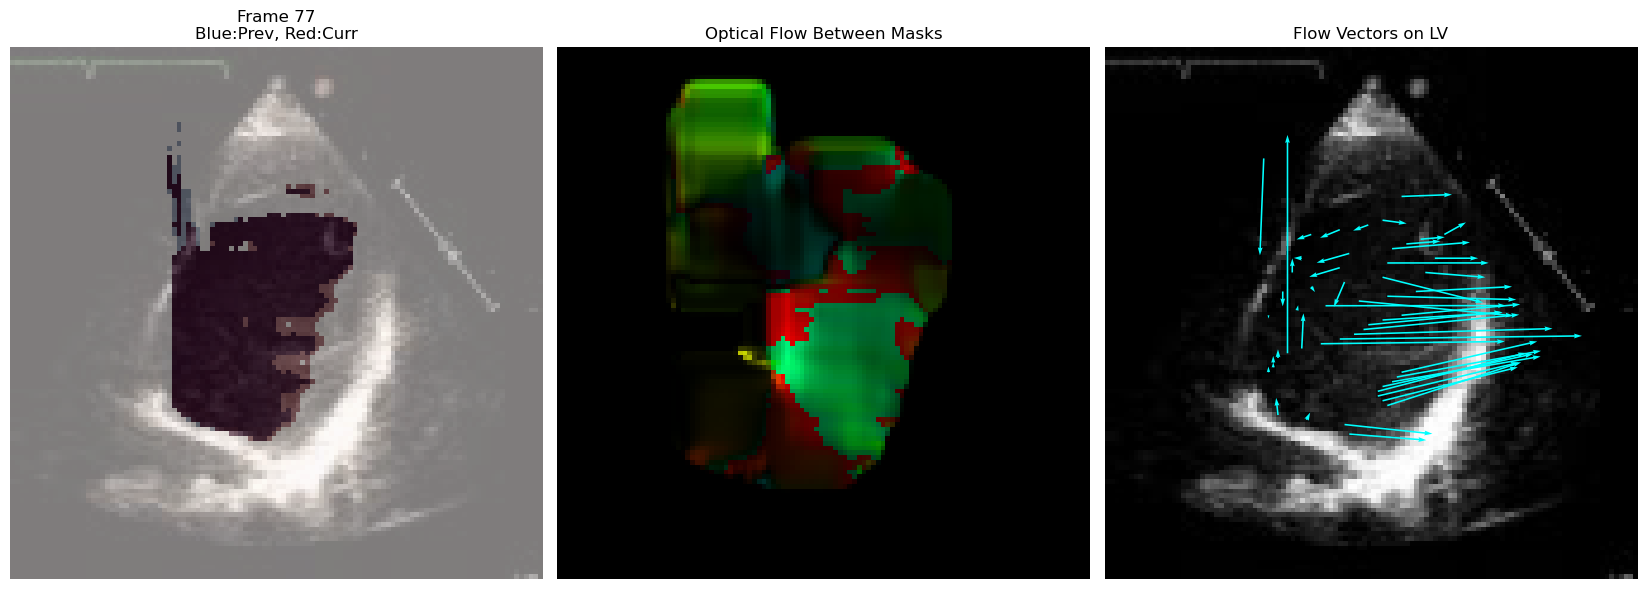


    ====== OPTICAL FLOW VALIDATION REPORT ======
    
    Input: ../data/raw/A4C/videos/CR32a7579-CR3dcadf1-000063.avi
    Frames Processed: 78
    
    Validation Criteria:
      - Maximum Allowable Flow Magnitude: 2.5 pixels

    Valid Frames Statistics:
      - Mean Flow Magnitude: 0.92 px
      - Mean Mask Area: 933 px
    
    Results:
      - Valid Frames: 77 (100.0%)
      - Discarded Frames: 0
    
    Ejection Fraction Calculation:
      - EDV: 122.2 ml (Frame 77)
      - ESV: 32.7 ml (Frame 60)
      - EF: 73.2%
    


In [101]:
validate_with_optical_flow("../data/raw/A4C/videos/CR32a7579-CR3dcadf1-000063.avi", model, device)